In [1]:
# Import module
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
# Import common libraries
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy.orm import sessionmaker

In [4]:
# Import the dependencies
from pathlib import Path
from sqlalchemy import create_engine, text
import pandas as pd

In [5]:
#  path to SQLite database file
database_path = "Resources/hawaii.sqlite" 

# Create the engine
engine = create_engine(f"sqlite:///{database_path}")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with =engine)

In [7]:
# View all of the classes that automap found
class_names = list(Base.classes.keys())
print(class_names)

['measurement', 'station']


In [8]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [9]:
# Create our session (link) from Python to the DB
Session = sessionmaker(bind=engine)
session = Session()

# Exploratory Precipitation Analysis

In [10]:
# Access the table class (replace 'Measurement' with your table class)
Measurement = Base.classes.measurement

In [11]:
# Query for the most recent date
result = session.query(func.max(Measurement.date)).scalar()

# Since result is a single value wrapped in a tuple, extract it directly
most_recent_date = result

print("Most Recent Date:", most_recent_date)

Most Recent Date: 2017-08-23


<Figure size 1000x500 with 0 Axes>

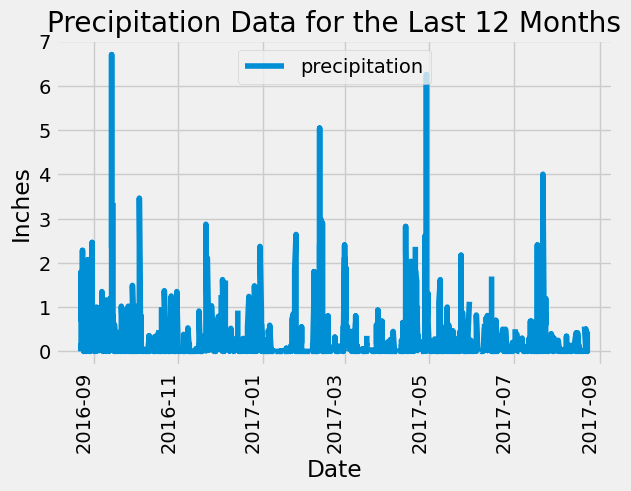

In [12]:
from datetime import datetime, timedelta

# Calculate the date one year before the most recent date
end_date = datetime.strptime(most_recent_date, '%Y-%m-%d')
start_date = end_date - timedelta(days=365)

# Perform a query to retrieve the last 12 months of precipitation data
query = session.query(Measurement.date, Measurement.prcp).filter(
    Measurement.date >= start_date.strftime('%Y-%m-%d')
).order_by(Measurement.date).statement

# Load the query results into a DataFrame
df = pd.read_sql(query, engine)

# Rename the columns if needed
df.columns = ['date', 'precipitation']

# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Sort the DataFrame by date
df = df.sort_values(by='date')

# Plot the data
plt.figure(figsize=(10, 5))
df.plot(x = 'date', y = 'precipitation', linestyle='-', rot = 90)
plt.title('Precipitation Data for the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend(loc='upper center')
plt.grid(True)
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = df['precipitation'].describe()

In [14]:
# Print the summary statistics
print(f"{' ':<8}precipitation")
print(f"count\t{summary_stats['count']:.6f}")
print(f"mean\t{summary_stats['mean']:.6f}")
print(f"std\t{summary_stats['std']:.6f}")
print(f"min\t{summary_stats['min']:.6f}")
print(f"25%\t{summary_stats['25%']:.6f}")
print(f"50%\t{summary_stats['50%']:.6f}")
print(f"75%\t{summary_stats['75%']:.6f}")
print(f"max\t{summary_stats['max']:.6f}")

        precipitation
count	2021.000000
mean	0.177279
std	0.461190
min	0.000000
25%	0.000000
50%	0.020000
75%	0.130000
max	6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station.distinct())).scalar()

# Print the result
print(f"Total number of stations: {total_stations}")

Total number of stations: 9


In [16]:
# Design a query to find the most active stations 
active_stations = (
    session.query(Measurement.station, func.count(Measurement.station).label('station_count'))
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc())
    .all()
)

# Convert to DataFrame
active_stations_df = pd.DataFrame(active_stations, columns=['station', 'station_count'])

# Display the result
print(active_stations_df)

       station  station_count
0  USC00519281           2772
1  USC00519397           2724
2  USC00513117           2709
3  USC00519523           2669
4  USC00516128           2612
5  USC00514830           2202
6  USC00511918           1979
7  USC00517948           1372
8  USC00518838            511


In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature
# Filter the temperature data for the most active station
most_active_station_id = active_stations_df.loc[active_stations_df['station_count'].idxmax(), 'station']

print (most_active_station_id)

USC00519281


In [18]:
# Query to calculate the lowest, highest, and average temperatures for the most active station (USC00519281)
results = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
                  .filter(Measurement.station == 'USC00519281').all()

# Extract the results
for min_temp, max_temp, avg_temp in results:
    print(f"Lowest Temperature: {min_temp}, Highest Temperature: {max_temp}, Average Temperature: {avg_temp}")

Lowest Temperature: 54.0, Highest Temperature: 85.0, Average Temperature: 71.66378066378067


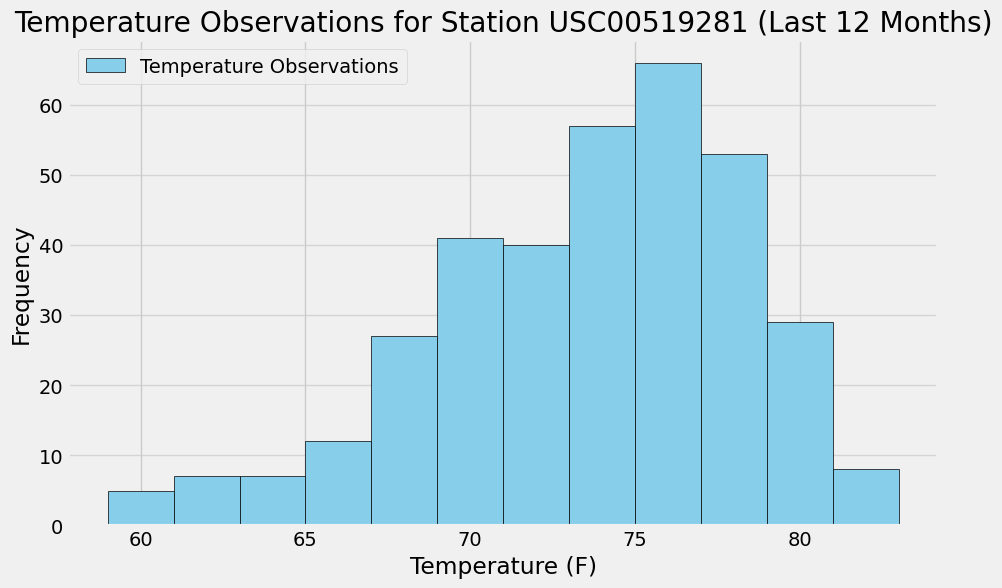

In [19]:
# Query to get the last 12 months of temperature data for the most active station
most_active_station_id = active_stations_df.loc[active_stations_df['station_count'].idxmax(), 'station']
results = session.query(Measurement.date, Measurement.tobs)\
                  .filter(Measurement.station == most_active_station_id)\
                  .filter(Measurement.date >= '2016-08-23').all()

# Create a DataFrame from the query results
temperature_data_df = pd.DataFrame(results, columns=['date', 'temperature'])

# Plot the data as a histogram with labels for the bars
plt.figure(figsize=(10, 6))
plt.hist(temperature_data_df['temperature'], bins=12, color='skyblue', edgecolor='black', label='Temperature Observations')
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.title(f'Temperature Observations for Station {most_active_station_id} (Last 12 Months)')
plt.grid(axis='y', alpha=0.75)
plt.legend()
plt.show()

# Close Session

In [20]:
# Close Session
session.close()